In [3]:
# data processing packages
import numpy as np
import pandas as pd
from pandas import DataFrame

# model packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.externals import joblib
from keras.models import load_model
import glob

# evaluation packages
from sklearn.metrics import roc_curve
from sklearn.model_selection import learning_curve

# plot packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# obtain valid data
signal_test = pd.read_hdf('./data/fullsignal_test.hdf','signal')
signal_test = signal_test.dropna()

feature_name = signal_test.columns.tolist()
feature_name.remove('eid')
feature_name.remove('truth_matching')
feature_name.remove('upsmcmass')
feature_name.remove('A1mcmass')
feature_name.remove('A2mcmass')
feature_name.remove('A3mcmass')

X_test = signal_test[feature_name]
y_test = signal_test['truth_matching']
print X_test.shape, y_test.shape

weight_test = np.zeros(y_test.shape)
weight_test = weight_test + 1
weight_test[y_test==1] = y_test.shape[0] / sum(y_test)

(676453, 17) (676453,)


/Users/yunxuanli/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:41: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


Plotting ROC curve...
./models/dt.pkl
./models/gbdt100.pkl
./models/lg.pkl


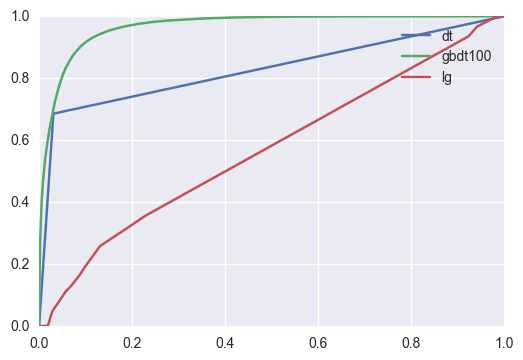

In [4]:
# ROC curve:
print 'Plotting ROC curve...'
model_list_sklearn = glob.glob('./models/*.pkl')
model_list_keras = glob.glob('./models/*.h5')
model_list = model_list_sklearn + model_list_keras

for model in model_list:
    print model
    if(model in model_list_sklearn):
        rf = joblib.load(model)
        y_pred_prob = rf.predict_proba(X_test)[:,1]
        fpr,tpr,thresholds = roc_curve(y_test, y_pred_prob, sample_weight=weight_test)
        plt.plot(fpr,tpr,label=model[9:-4])
    elif(model in model_list_keras):
        rf = load_model(model)
        y_pred_prob = rf.predict(X_test.values)
        fpr,tpr,thresholds = roc_curve(y_test.values, y_pred_prob, sample_weight=weight_test)
        plt.plot(fpr,tpr,label=model[9:-3])
    else:
        print 'Error'

plt.legend()

In [6]:
temp = [[0,1,1,0],[1,1,float('nan'),0],[0,2,3,1],[float('nan'),float('nan'),float('nan'),float('nan')]]
df = pd.DataFrame(temp)

In [19]:
df = pd.read_hdf('./data/fullsignal_test.hdf','signal')
df_1 = df[df.isnull().any(axis=1)]

In [2]:
# calculate cr_score for test set using gbdt100
rf = joblib.load('./models/gbdt100.pkl')
signal_test['cr_score'] = pd.Series(rf.predict_proba(signal_test[feature_name])[:,1], index=signal_test.index)

# use highest cr_score to construct event table
"""
event_list = []
for eid, candidates in signal_test.groupby('eid'):
    event_list.append(candidates.ix[candidates['cr_score'].argmax()])
events_test = DataFrame(event_list, columns=signal_test.columns)
events_test.to_hdf('./data/events_test.hdf','event')
"""
events_test = pd.read_hdf('./data/events_test.hdf','event')

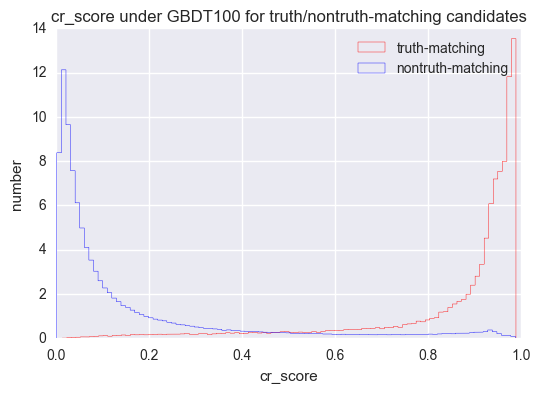

In [3]:
#plt.hist((events_test.upsmcmass - events_test.upsmass),bins=100,range=[0,1])
#plt.hist((events_test.A1mcmass - events_test.A1mass),bins=100,range=[0,0.5])
plt.hist(signal_test[signal_test.truth_matching==True].cr_score, bins=100, color='r',label='truth-matching',histtype='step', normed=True)
plt.hist(signal_test[signal_test.truth_matching==False].cr_score, bins=100, color='b',label='nontruth-matching',histtype='step', normed=True)
plt.legend()
plt.xlabel('cr_score')
plt.ylabel('number')
plt.title('cr_score under GBDT100 for truth/nontruth-matching candidates')

3.5195855
0.8485428

40.9334988268


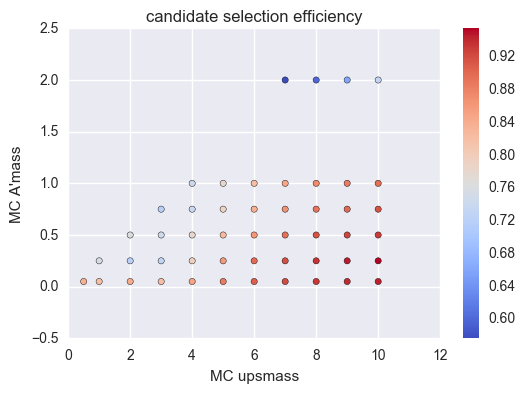

In [8]:
# efficiency for gbdt100 under different (upsmcmass, Amcmass) pairs

# hyperparameters: box size and threshold
delta = 0.1
percentile = 99
delta_ups = np.percentile((events_test.upsmcmass - events_test.upsmass), percentile)
delta_A = np.percentile((events_test.A1mcmass - events_test.A1mass), percentile)
update_delta = []
threshold = 0.6
print delta_ups
print delta_A
print

# MC hypothesises
upsmcmass_list = [0.5, 1., 2., 3., 4., 5., 6., 7., 8., 9., 10.]
Amcmass_list = [0.05, 0.25, 0.5, 0.75, 1.0, 2.0]
mcmass_list = [[upsmcmass, Amcmass] for upsmcmass in upsmcmass_list for Amcmass in Amcmass_list if upsmcmass>3*Amcmass]
N_count_list = []

for upsmcmass_, Amcmass_ in mcmass_list:
    # events under a certain (upsmass, Amcmass) hypothesis pair
    filte = (events_test.upsmcmass<upsmcmass_+delta_ups) & (events_test.upsmcmass>upsmcmass_-delta_ups) \
        & (events_test.A1mcmass<Amcmass_+delta_A) & (events_test.A1mcmass>Amcmass_-delta_A) \
        & (events_test.upsmass<upsmcmass_+delta_ups) & (events_test.upsmass>upsmcmass_-delta_ups) \
        & (events_test.A1mass<Amcmass_+delta_A) & (events_test.A1mass>Amcmass_-delta_A)
    events_singleMChypothesis = events_test[filte]
    
    update_delta_ups = np.percentile(events_singleMChypothesis.upsmcmass - events_singleMChypothesis.upsmass,
                                     97)
    update_delta_A = np.percentile(events_singleMChypothesis.A1mcmass - events_singleMChypothesis.A1mass,
                                     97)
    update_delta.append([update_delta_ups, update_delta_A])
    #print update_delta_ups, update_delta_A
    update_filte = (events_test.upsmcmass<upsmcmass_+update_delta_ups) & (events_test.upsmcmass>upsmcmass_-update_delta_ups) \
        & (events_test.A1mcmass<Amcmass_+update_delta_A) & (events_test.A1mcmass>Amcmass_-update_delta_A) \
        & (events_test.upsmass<upsmcmass_+update_delta_ups) & (events_test.upsmass>upsmcmass_-update_delta_ups) \
        & (events_test.A1mass<Amcmass_+update_delta_A) & (events_test.A1mass>Amcmass_-update_delta_A)
    events_singleMChypothesis = events_singleMChypothesis[update_filte]
    
    # number of signals
    N_count = events_singleMChypothesis[events_singleMChypothesis.cr_score > threshold].shape[0]
    if N_count==0:
        N_count_list.append(0)
    else:
        N_count_list.append(N_count*1.0/events_singleMChypothesis.shape[0])

print sum(N_count_list)
# plot
from matplotlib import cm
mcmass_np = np.array(mcmass_list)
plt.scatter(mcmass_np[:,0], mcmass_np[:,1], c=N_count_list, cmap=cm.coolwarm)
plt.colorbar()
plt.xlabel('MC upsmass')
plt.ylabel('MC A\'mass')
plt.title('candidate selection efficiency')

In [54]:
print update_delta

[[0.78653839999999964, 0.1379859519999995], [0.77693479999999837, 0.13647083999999993], [0.79668119999999965, 0.22323905999999938], [1.0075131000000004, 0.13721019300000015], [1.0187183000000002, 0.2227445099999997], [1.0219561999999991, 0.22191265999999976], [1.1575834000000003, 0.13593030000000023], [1.1775326999999995, 0.20759058999999949], [1.1870627999999996, 0.2062382399999981], [1.1871385999999995, 0.20552949999999987], [1.3151222999999999, 0.13845330000000003], [1.3423501999999992, 0.20374221999999997], [1.3537209999999951, 0.20302379999999967], [1.3575650999999997, 0.2029341300000001], [1.3106566999999969, 0.23762514999999995], [1.4561579999999996, 0.13846061999999998], [1.4916113999999978, 0.19819807999999964], [1.5040554999999998, 0.19743700999999997], [1.5095037999999912, 0.19737401999999979], [1.4575431999999993, 0.22804079999999993], [1.6278334999999999, 0.13608956999999991], [1.6487320999999997, 0.19081363999999995], [1.6654900000000006, 0.18983860000000002], [1.67279679

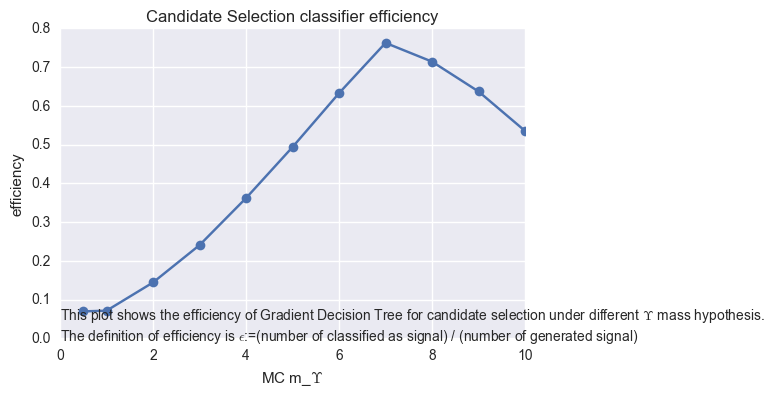

In [40]:
# MC hypothesises
upsmcmass_list = [0.5, 1., 2., 3., 4., 5., 6., 7., 8., 9., 10.]
#Amcmass_list = [0.05, 0.25, 0.5, 0.75, 1.0, 2.0]
#mcmass_list = [[upsmcmass, Amcmass] for upsmcmass in upsmcmass_list for Amcmass in Amcmass_list if upsmcmass>3*Amcmass]
N_count_list = []

for upsmcmass_ in upsmcmass_list:
    # events under a certain (upsmass, Amcmass) hypothesis pair
    filte = (events_test.upsmcmass<upsmcmass_+delta_ups) & (events_test.upsmcmass>upsmcmass_-delta_ups) \
        & (events_test.upsmass<upsmcmass_+delta_ups) & (events_test.upsmass>upsmcmass_-delta_ups)
    events_singleMChypothesis = events_test[filte]
    
#    update_ups, update_A = 
    # number of signals
    N_count = events_singleMChypothesis[events_singleMChypothesis.cr_score > threshold].shape[0]
    N_count_list.append(N_count*1.0/events_test.shape[0])

plt.plot(upsmcmass_list, N_count_list,'-o')
plt.xlabel('MC m_$\Upsilon$')
plt.ylabel('efficiency')
plt.title('Candidate Selection classifier efficiency')
txt = "This plot shows the efficiency of Gradient Decision Tree for candidate selection under different $\Upsilon$ mass hypothesis.\n\
The definition of efficiency is $\epsilon$:=(number of classified as signal) / (number of generated signal)"
plt.text(.0, -.005, txt)

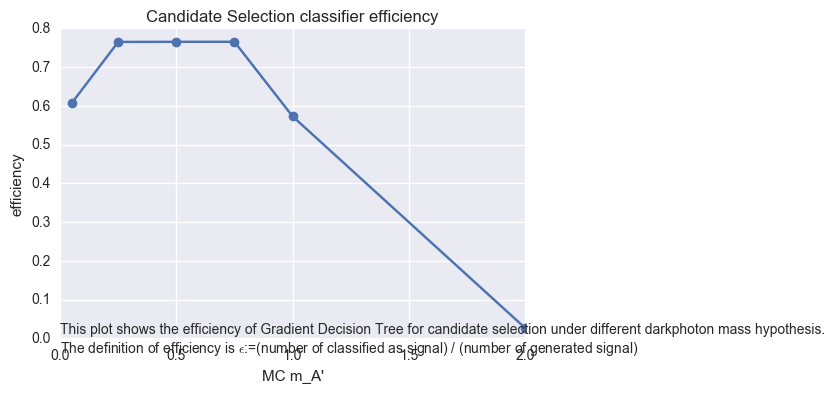

In [41]:
# MC hypothesises
#upsmcmass_list = [0.5, 1., 2., 3., 4., 5., 6., 7., 8., 9., 10.]
Amcmass_list = [0.05, 0.25, 0.5, 0.75, 1.0, 2.0]
#mcmass_list = [[upsmcmass, Amcmass] for upsmcmass in upsmcmass_list for Amcmass in Amcmass_list if upsmcmass>3*Amcmass]
N_count_list = []

for Amcmass_ in Amcmass_list:
    # events under a certain (upsmass, Amcmass) hypothesis pair
    filte = (events_test.A1mcmass<Amcmass_+delta_A) & (events_test.A1mcmass>Amcmass_-delta_A) \
        & (events_test.A1mass<Amcmass_+delta_A) & (events_test.A1mass>Amcmass_-delta_A)
    events_singleMChypothesis = events_test[filte]
    
    # number of signals
    N_count = events_singleMChypothesis[events_singleMChypothesis.cr_score > threshold].shape[0]
    N_count_list.append(N_count*1.0/events_test.shape[0])

plt.plot(Amcmass_list, N_count_list,'-o')
plt.xlabel('MC m_A\'')
plt.ylabel('efficiency')
plt.title('Candidate Selection classifier efficiency')
txt = "This plot shows the efficiency of Gradient Decision Tree for candidate selection under different darkphoton mass hypothesis.\n\
The definition of efficiency is $\epsilon$:=(number of classified as signal) / (number of generated signal)"
plt.text(0, -0.04, txt)

4.0 0.5
1.353721 0.2030238
(3383, 24)
('MC shape is', (4331, 24))


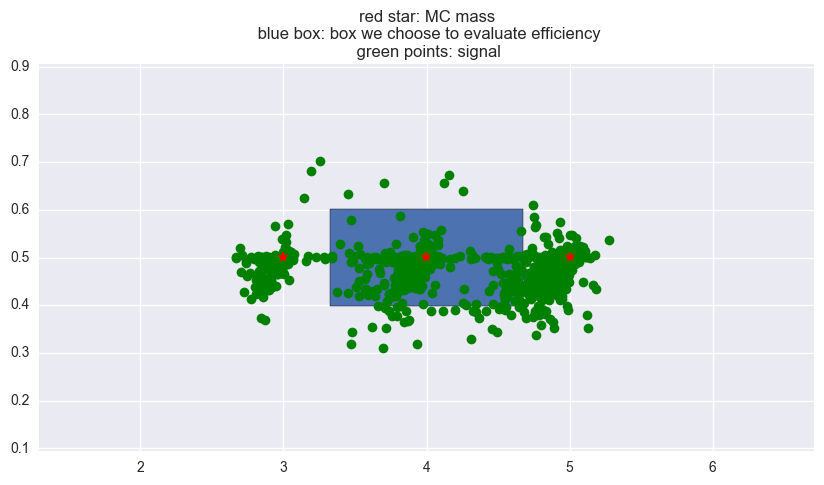

In [6]:
index = 12
upsmcmass_, Amcmass_ = mcmass_list[index]
update_delta_ups, update_delta_A = update_delta[index]
print upsmcmass_,Amcmass_
print update_delta_ups, update_delta_A
filte = (events_test.upsmcmass<upsmcmass_+update_delta_ups) & (events_test.upsmcmass>upsmcmass_-update_delta_ups) \
        & (events_test.A1mcmass<Amcmass_+update_delta_A) & (events_test.A1mcmass>Amcmass_-update_delta_A) \
        & (events_test.upsmass<upsmcmass_+update_delta_ups) & (events_test.upsmass>upsmcmass_-update_delta_ups) \
        & (events_test.A1mass<Amcmass_+update_delta_A) & (events_test.A1mass>Amcmass_-update_delta_A)
        
events_singleMC = events_test[filte]
events_signal = events_singleMC[events_singleMC.cr_score > threshold]
print events_signal.shape
print('MC shape is', events_singleMC.shape)
import matplotlib.patches as patches
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)
ax1.add_patch(
            patches.Rectangle(
                (upsmcmass_-update_delta_ups/2.0, Amcmass_-update_delta_A/2.0),
                update_delta_ups,
                update_delta_A,))
#plt.plot(events_singleMC.upsmass, events_singleMC.A1mass,'o', color='b')
ax1.plot(events_signal.upsmass, events_signal.A1mass,'o', color='g')
ax1.plot(events_singleMC.upsmcmass, events_singleMC.A1mcmass,'*', color='r')
plt.xlim(upsmcmass_-2*update_delta_ups, upsmcmass_+2*update_delta_ups)
plt.ylim(Amcmass_-2*update_delta_A, Amcmass_+2*update_delta_A)
txt = 'red star: MC mass\n blue box: box we choose to evaluate efficiency\n green points: signal'
plt.title(txt)